In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d vbookshelf/rice-leaf-diseases
!unzip rice-leaf-diseases.zip

Dataset URL: https://www.kaggle.com/datasets/vbookshelf/rice-leaf-diseases
License(s): unknown
 74% 27.0M/36.7M [00:00<00:00, 130MB/s] 
100% 36.7M/36.7M [00:00<00:00, 101MB/s]
Archive:  rice-leaf-diseases.zip
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0365.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0366.jpg  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0367.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0370.jpg  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0372.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0373.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0374.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0375.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0376.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0377.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0378.JPG  
  inflating: rice_leaf_diseases/

In [ ]:
data_dir = 'rice_leaf_diseases'

In [ ]:
# Parameters
img_size = 224
batch_size = 32

# Create data generators for training and validation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 96 images belonging to 3 classes.
Found 24 images belonging to 3 classes.


In [ ]:
from tensorflow.keras import layers, models

# Define the CNN model with explicit Input layer
model = models.Sequential([
    layers.Input(shape=(img_size, img_size, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

In [ ]:
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    epochs=8,
    validation_data=val_generator
)

Epoch 1/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.5729 - loss: 1.6173 - val_accuracy: 0.5417 - val_loss: 0.8048
Epoch 2/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 341ms/step - accuracy: 0.6341 - loss: 0.8285 - val_accuracy: 0.7917 - val_loss: 0.4988
Epoch 3/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 300ms/step - accuracy: 0.7604 - loss: 0.5470 - val_accuracy: 0.7083 - val_loss: 0.5823
Epoch 4/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 357ms/step - accuracy: 0.8620 - loss: 0.4489 - val_accuracy: 0.7500 - val_loss: 0.5969
Epoch 5/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 357ms/step - accuracy: 0.7773 - loss: 0.4177 - val_accuracy: 0.7083 - val_loss: 0.6429
Epoch 6/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 291ms/step - accuracy: 0.9323 - loss: 0.1750 - val_accuracy: 0.7917 - val_loss: 0.6586
Epoch 7/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 290ms/step - accuracy: 0.9102 - loss: 0.1923 - val_accuracy: 0.7500 - val_loss: 0.5113
Epoch 8/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 443ms/step - accuracy: 0.9440 - loss: 0.1739 - val_accuracy: 0.8333 - val_loss: 0.3184


In [ ]:
# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step - accuracy: 0.7917 - loss: 0.4777
Validation Accuracy: 79.17%


In [ ]:
# Function to load and preprocess images
def load_and_prep_image(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))
    img = np.array(img) / 255.0
    return img.reshape(1, img_size, img_size, 3)

# Load and predict on an unseen image
unseen_image = load_and_prep_image('test.jpg')
predictions = model.predict(unseen_image)
predicted_class = np.argmax(predictions, axis=-1)

class_labels = train_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}

print(f"Predicted class: {class_labels[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: Brown spot


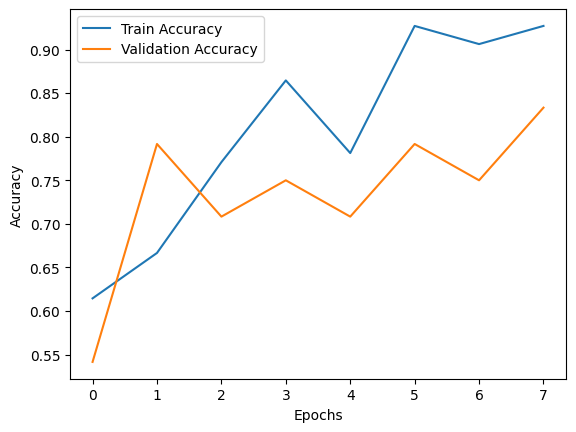

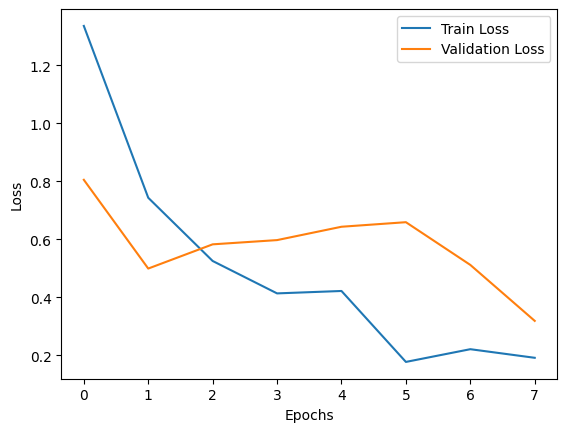

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
